In [3]:
import tensorflow as tf
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
building_dir = './mass_buildings'
os.listdir(building_dir)

['.DS_Store', 'test', 'train']

In [4]:
def load_image_paths(path,name):
    
    #images-to-path dierctory
    images= {name: {'train': defaultdict(dict), 'test': defaultdict(dict), 'valid': defaultdict(dict)}}
    
    #taking out the .ds stores that mac has
    ttv = [f for f in os.listdir(path) if '.DS_Store' not in f]
    
    
    for ttv_typ in ttv:
        #joining path to train/test folders
        typ_path = os.path.join(path, ttv_typ)
        
        mapsat = [f for f in os.listdir(typ_path) if '.DS_Store' not in f]
        
        for ms_typ in mapsat:
            # for each folder (train,test) get the image paths
            ms_path = os.path.join(typ_path, ms_typ)
            ms_img_files = os.listdir(ms_path)
            
            #keep only tif
            ms_img_files = [f for f in ms_img_files if f.endswith('.tiff') or f.endswith('.tif')]
            
            # get the image id (take off tif ending)
            scene_ids = [f.replace('.tiff','').replace('.tif','') for f in ms_img_files]
            
            
            #joining the whole path
            ms_img_files = [os.path.join(ms_path,f) for f in ms_img_files]
            
            #FILLING OUT IMAGES-TO-PATH DICTIONARY
            for f, scene_id in zip(ms_img_files,scene_ids):
                images[name][ttv_typ][scene_id][ms_typ] = f
                
    return images

In [5]:
def show_images(x,y):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    m = plt.imshow(x)
    plt.colorbar(m, fraction=.046,pad=0.04)
    
    plt.subplot(1,2,2)
    m = plt.imshow(y[:,:,0], vmin=0,vmax=1)
    plt.colorbar(m, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [6]:
images = load_image_paths(building_dir, 'roads')

In [10]:
def data_generator(files, size=128, mode ='train', batch_size=32):
    while True:
        all_scenes = list(files[mode].keys())
        
        scene_id = np.random.choice(all_scenes, size=batch_size, replace=True)
        # these are raw image data to be fed through PIL.Image
        X_files = [files[mode][scene_i]['sat'] for scene_i in scene_id]
        Y_files = [files[mode][scene_i]['map'] for scene_i in scene_id]
        
        X = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in X_files])
        Y = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in Y_files])
        
        n, h, w, c = X.shape
        
        #choosing random block from the huge image for data conservation
        I = np.random.randint(0,h-size, size=batch_size)
        J = np.random.randint(0,w-size,size=batch_size)
        
        X = np.array([x[i:(i+size),j:(j+size)] for x, i, j in zip(X,I,J)])
        Y = np.array([y[i:(i+size),j:(j+size)] for y, i, j in zip(Y,I,J)])
        
        yield X, np.expand_dims(Y,axis=-1)

In [11]:
train_road_gen = data_generator(images['roads'])

In [12]:
X,Y = next(train_road_gen)

<ipython-input-10-6f7ae143c5e4>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in X_files])
<ipython-input-10-6f7ae143c5e4>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in Y_files])


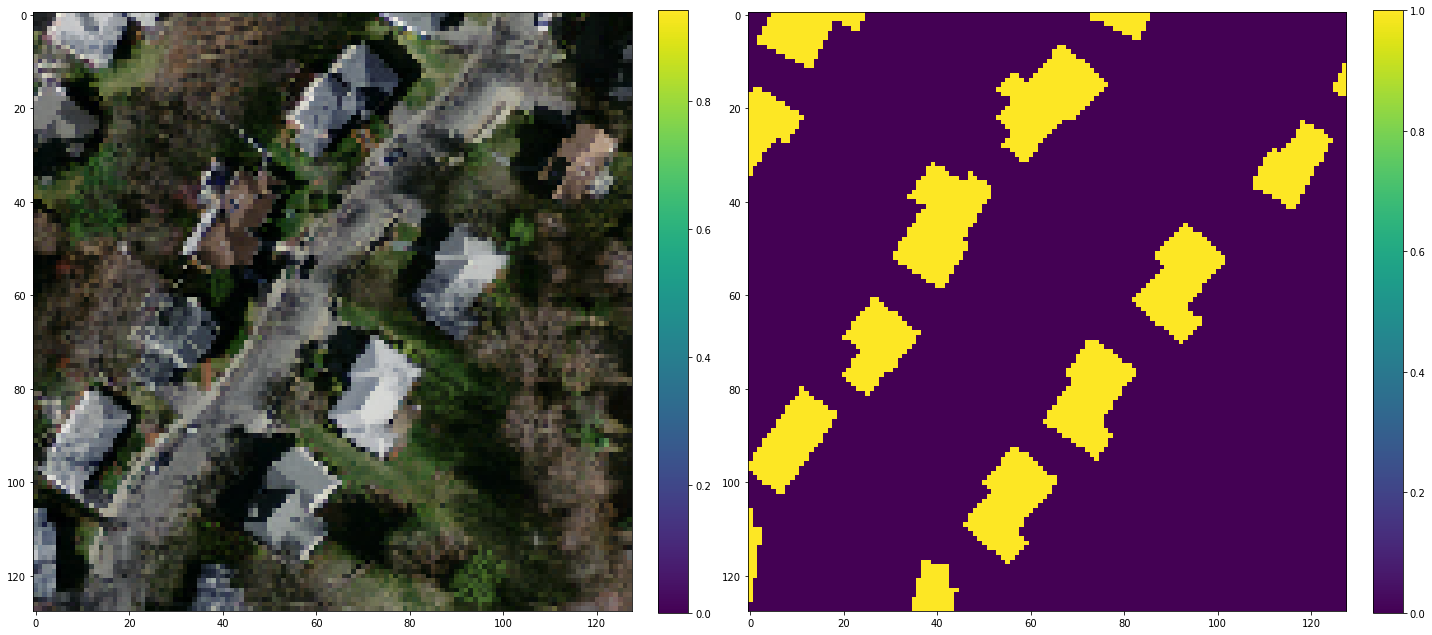

In [13]:
show_images(X[0],Y[0])

# Trying to code a U-Net architecture off of a diagram

## testing my ability to code a complex NN without a template

In [14]:
from tensorflow.keras.layers import Activation, Reshape, Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv1D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model

def build_model(input_shape,channels,dropout_rate=0.2):
    I = Input(shape=input_shape)
    x = BatchNormalization()(I)
    skip_copy = list()
    for n_c in channels:
        x,s = build_unet_block_down(x,n_c,k_size=3)
        skip_copy.append(s)
    # at bottom
    x = BatchNormalization(x)
    x = Conv2D(channels[-1]*2,kernel_size=(3,3),padding='same',activation='relu')
    x = Conv2D(channels[-1]*2,kernel_size=(3,3),padding='same',activation='relu')
    for n_c in channels[::-1]: 
        x = build_unet_block_up(x,n_c,3,skip_copy,dropout_rate)
        
    # now at output phase
    x = Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')

    model = Model(inputs=I,outputs=x)
    return model  
def build_unet_block_down(x,num_ch,k_size):
    x = BatchNormalization()(x)
    x = Conv2D(num_ch,kernel_size=(k_size,k_size),padding='same',activation='relu')(x)
    s = Conv2D(num_ch,kernel_size=(k_size,k_size),padding='same',activation='relu')(x)
    s = Reshape(x.shape)(s)
    x = MaxPooling2D()(s)
    return x,s

def build_unet_block_up(x,n_c,k_size,skips,dropout_rate):
    x = Upsampling2D()(x)
    x = Concatenate()(x,skips.pop())
    x = Dropout(dropout_rate)
    x = BatchNormalization()(x)
    x = Conv2D(num_ch,kernel_size=(k_size,k_size),padding='same',activation='relu')(x)
    x = Conv2D(num_ch,kernel_size=(k_size,k_size),padding='same',activation='relu')(x)
    return x

In [15]:
# i dont know what happened the skip connect didnt work did too much coding at once

In [16]:
def build_block(x,num_f,skip_connect = True):
    x = BatchNormalization()(x)
    
    x = Conv2D(num_f,kernel_size=3,padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(num_f,kernel_size=3,padding='same')(x)
    s = Activation('relu')(x)
    if skip_connect == True:
        x = MaxPooling2D(pool_size=2)(s)
    
    return x,s
    

In [17]:
def build_model(input_shape,filters=32, dropout_rate = 0.25):
    I = Input(shape = input_shape)
    
    #block 1 256x256, 64 (x.size input, num filters)
    x, s1 = build_block(I,filters,True)
    #block 2, 128x128,128
    x, s2 = build_block(x,filters*2,True)
    #block 3, 64x64, 256
    x, s3 = build_block(x,filters*4,True)
    #bottom block, 32x32, 512
    x, _ = build_block(x,filters*8,False)
    #block 4 up, 64x64
    x_up = UpSampling2D()(x)
    x = Concatenate()([x_up, s3])
    x = Dropout(dropout_rate)(x)
    x, _ = build_block(x,filters*4,False)
    #block 5 up, 128x128
    x_up = UpSampling2D()(x)
    x = Concatenate()([x_up, s2])
    x = Dropout(dropout_rate)(x)
    x, _ = build_block(x,filters*2,False)
    # block 6 up, 256x256
    x_up = UpSampling2D()(x)
    x = Concatenate()([x_up, s1])
    x = Dropout(dropout_rate)(x)
    x, _ = build_block(x,filters*4,False)
    
    #output conv
    x = Conv2D(1,kernel_size=3,padding='same')(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=I,outputs=x)
    model.compile(loss=BinaryCrossentropy(), optimizer=Adam())
    
    return model

In [18]:
X.shape

(32, 128, 128, 3)

In [19]:
model = build_model(X[0].shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['batch_normalization[0][0]']    
                                )                                                             

In [ ]:
model.fit(train_road_gen, steps_per_epoch=10, epochs=10)

<ipython-input-10-6f7ae143c5e4>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in X_files])
<ipython-input-10-6f7ae143c5e4>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.array([np.asarray(Image.open(f), dtype=np.float) / 255 for f in Y_files])


Epoch 1/25
10/10 [==============================] - 284s 29s/step - loss: 0.2737
Epoch 2/25
10/10 [==============================] - 265s 27s/step - loss: 0.1408
Epoch 3/25
10/10 [==============================] - 258s 26s/step - loss: 0.1506
Epoch 4/25
10/10 [==============================] - 255s 25s/step - loss: 0.1364
Epoch 5/25
10/10 [==============================] - 457s 48s/step - loss: 0.1318
Epoch 6/25
10/10 [==============================] - 261s 26s/step - loss: 0.1297
Epoch 7/25
10/10 [==============================] - 326s 33s/step - loss: 0.1302
Epoch 8/25
10/10 [==============================] - 261s 26s/step - loss: 0.1356
Epoch 9/25
10/10 [==============================] - 256s 25s/step - loss: 0.1373
Epoch 10/25
10/10 [==============================] - 253s 25s/step - loss: 0.1358
Epoch 11/25
10/10 [==============================] - 528s 31s/step - loss: 0.1303
Epoch 12/25
10/10 [==============================] - 264s 26s/step - loss: 0.1301
Epoch 13/25
10/10 [======

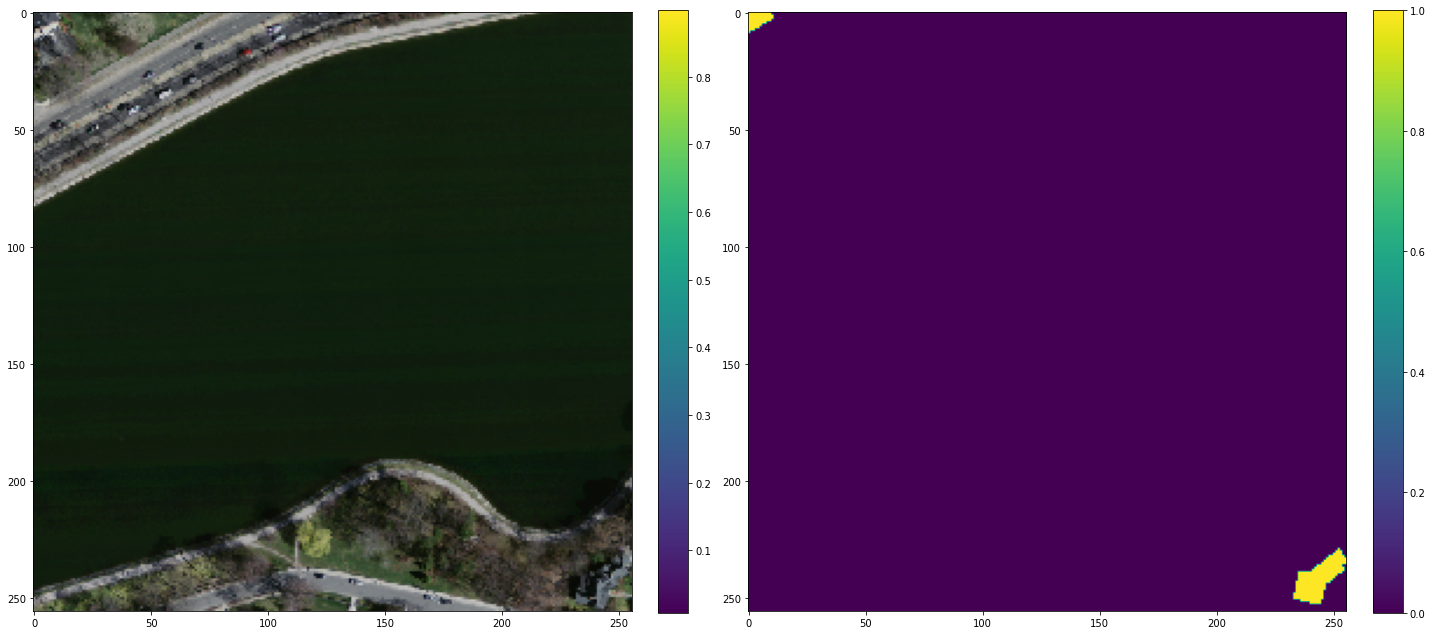

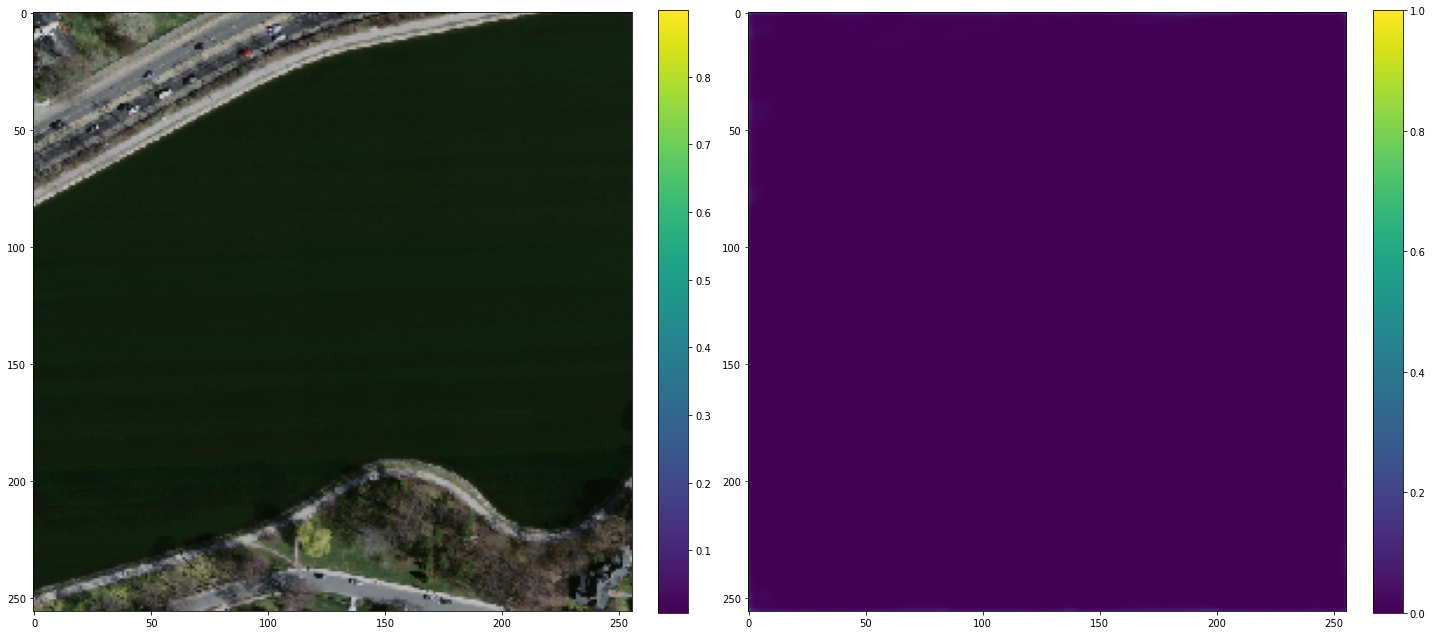

In [18]:
Z = model.predict(X)
i=13

show_images(X[i],Y[i])
show_images(X[i],Z[i])

# Due to how small the images have to be to run the code enough to learn features, the output will be skewed towards blank-type zero detection. Since there will potentially be minimal buildings seen in a given batch

## If I were to try and improve this, I would create a way to correct the imbalance, purposely weighting selction of buildings-heaviy image aptches to help speed up learning

In [2]:
def get_image_prediction(image, model, size=256):
  prediction = np.zeros_like(image[:,:,:1])

  h, w, c = image.shape
  for i in range(0, h-size, size):
    for j in range(0, w-size, size):
      chip = image[i:i+size, j:j+size]
      prediction[i:i+size, j:j+size] = model.predict(chip.reshape(1, size, size, c))

  for i in range(0, h-size, size):
    chip = image[i:i+size, w-size:]
    prediction[i:i+size, w-size:] = model.predict(chip.reshape(1, size, size, c))

  for j in range(0, w-size, size):
    chip = image[h-size:, j:j+size]
    prediction[h-size:, j:j+size] = model.predict(chip.reshape(1, size, size, c))

  chip = image[h-size:, w-size:]
  prediction[h-size:, w-size:] = model.predict(chip.reshape(1, size, size, c))

  return prediction

def compute_f1_score(paths, model, mode="test"):
  agg_tp = 0
  agg_fp = 0
  agg_fn = 0
  for image_name in tqdm(paths[mode]):
    image_path = paths[mode][image_name]["sat"]
    label_path = paths[mode][image_name]["map"]
        
    image = np.asarray(Image.open(image_path), dtype=np.float) / 255
    label = np.asarray(Image.open(label_path), dtype=np.float) / 255
    label = np.expand_dims(label, axis=-1)
          
    prediction = get_image_prediction(image, model)

    num_positives = np.sum(label)
    num_detections = np.sum(prediction)
    tp = np.sum(label * prediction)
    fp = num_detections - tp
    fn = num_positives - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    print(f"Image name: {image_name}")
    print(f"Image precision: {precision}")
    print(f"Image recall: {recall}")
    print(f"Image f1 score: {f1}")
    print("-"*50)

    agg_tp += tp
    agg_fp += fp
    agg_fn += fn

  precision = agg_tp / (agg_tp + agg_fp)
  recall = agg_tp / (agg_tp + agg_fn)
  f1 = 2 * precision * recall / (precision + recall)

  print(f"Overall precision: {precision}")
  print(f"Overall recall: {recall}")
  print(f"Overall f1 score: {f1}")
